### Load according data

In [87]:
import pandas as pd
import oemof.solph as solph


#restore and load energy system
energy_system = solph.EnergySystem()
energy_system.restore('C:\\Users\\ann82611\\ownCloud\\U-Platte\\04_Code\\hydrogen_hub\\h2_hub_minimalschnitt\\h2_hub_dumps', 'h2_hub_dump.oemof')

results_main = energy_system.results['main']
results_meta = energy_system.results['meta'] #for costs

# Convert the results to a DataFrame
results = pd.Series(results_main)
results_meta_pd = pd.Series(results_meta)
print(results.info())
#print(results.describe())


<class 'pandas.core.series.Series'>
MultiIndex: 15 entries, ("<oemof.solph.buses._bus.Bus: 'co2_emissions_bus'>", "<oemof.solph.components._sink.Sink: 'co2_emissions'>") to ("<oemof.solph.components._source.Source: 'wind'>", "<oemof.solph.buses._bus.Bus: 'electricity'>")
Series name: None
Non-Null Count  Dtype 
--------------  ----- 
15 non-null     object
dtypes: object(1)
memory usage: 934.0+ bytes
None


## System Performance
The system performance is defined per below consisting of:
* Electricity deliverd to steel mill
* Hydrogen deliverd to steel mill
* Co2 Emissions
* Costs #aufsummierte kosten

Please keep in mind that the definition of the system performance may vary over time and also to the considered system accordingly.

In [88]:
#Schlüssel sind objekte (keine Strings!) 

# get df flows 
flow_el_steel = results.loc[(energy_system.node['electricity'], energy_system.node['steel_mill'])]['sequences']
flow_h2_steel = results.loc[(energy_system.node['h2_bus'],  energy_system.node['steel_mill'])]['sequences']
flow_co2 = results.loc[(energy_system.node['co2_emissions_bus'],  energy_system.node['co2_emissions'])]['sequences']
steel_produced = results.loc[(energy_system.node['steel_mill'],  energy_system.node['steel'])]['sequences']
operating_costs = results_meta_pd['objective']
print(operating_costs)

#extract values from df flows
flow_el_steel_values = flow_el_steel['flow']
flow_h2_steel_values = flow_h2_steel['flow']
flow_co2_values = flow_co2['flow']
steel_produced_values = steel_produced['flow']
operating_costs_values = [operating_costs] * (len(flow_co2_values))
# Füge die Betriebskosten hinzu, falls sie ein skalarer Wert sind
# system_performance['operating_costs'] = [operating_costs] * len(system_performance)

# Turn into combined DataFrame
system_performance = pd.DataFrame({'flow_co2': flow_co2_values, 'flow_el_steel': flow_el_steel_values, 'flow_h2_steel': flow_h2_steel_values, 'steel_produced': steel_produced_values, 'operating_costs': operating_costs_values})
# print(system_performance.info())
print(system_performance.describe())
print(system_performance.head())


-641.6687338070664
       flow_co2  flow_el_steel  flow_h2_steel  steel_produced  operating_costs
count    8760.0    8760.000000    8760.000000     8760.000000     8.761000e+03
mean        0.0      22.396290     602.053600        0.014650    -6.416687e+02
std         0.0      13.367253     359.336420        0.008744     1.136933e-13
min        -0.0       0.000000       0.000000        0.000000    -6.416687e+02
25%        -0.0      11.753121     315.945592        0.007688    -6.416687e+02
50%        -0.0      23.827143     640.517585        0.015586    -6.416687e+02
75%         0.0      30.585738     822.201087        0.020007    -6.416687e+02
max        -0.0      62.736673    1686.477500        0.041038    -6.416687e+02
                     flow_co2  flow_el_steel  flow_h2_steel  steel_produced  \
2019-01-01 00:00:00      -0.0      27.268820      733.03619        0.017837   
2019-01-01 01:00:00      -0.0      27.826467      748.02679        0.018202   
2019-01-01 02:00:00      -0.0    

c:\Users\ann82611\AppData\Local\Programs\Python\Python312\Lib\site-packages\oemof\network\energy_system.py:205: ExperimentalFeatureWarning: The API to access nodes by label is experimental and might change without prior notice.
  warnings.warn(msg, debugging.ExperimentalFeatureWarning)


### Plot System Performance

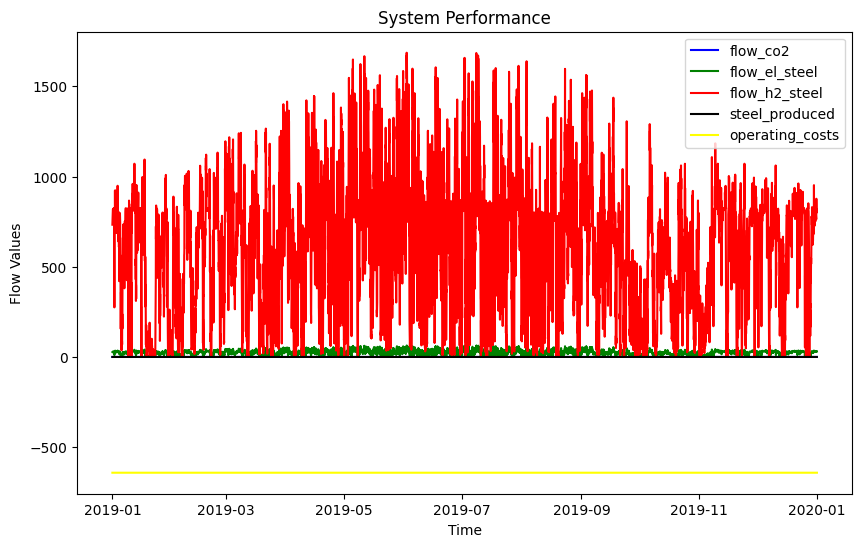

In [89]:
import matplotlib.pyplot as plt

# Erstelle eine Figur und eine Achse
plt.figure(figsize=(10, 6))

# Plotte die drei Zeitreihen
plt.plot(system_performance.index, system_performance['flow_co2'], label='flow_co2', color='blue')
plt.plot(system_performance.index, system_performance['flow_el_steel'], label='flow_el_steel', color='green')
plt.plot(system_performance.index, system_performance['flow_h2_steel'], label='flow_h2_steel', color='red')
plt.plot(system_performance.index, system_performance['steel_produced'], label='steel_produced', color='black')
plt.plot(system_performance.index, system_performance['operating_costs'], label='operating_costs', color='yellow')

# Füge Titel und Beschriftungen hinzu
plt.title('System Performance')
plt.xlabel('Time')
plt.ylabel('Flow Values')

# Füge eine Legende hinzu
plt.legend()

# Zeige die Abbildung an
plt.show()

                     flow_co2  flow_el_steel  flow_h2_steel  steel_produced  \
2019-01-01 00:00:00       0.0       0.434655       0.434655        0.434655   
2019-01-01 01:00:00       0.0       0.443544       0.443544        0.443544   
2019-01-01 02:00:00       0.0       0.447586       0.447586        0.447586   
2019-01-01 03:00:00       0.0       0.467603       0.467603        0.467603   
2019-01-01 04:00:00       0.0       0.479624       0.479624        0.479624   

                     operating_costs  
2019-01-01 00:00:00              0.0  
2019-01-01 01:00:00              0.0  
2019-01-01 02:00:00              0.0  
2019-01-01 03:00:00              0.0  
2019-01-01 04:00:00              0.0  


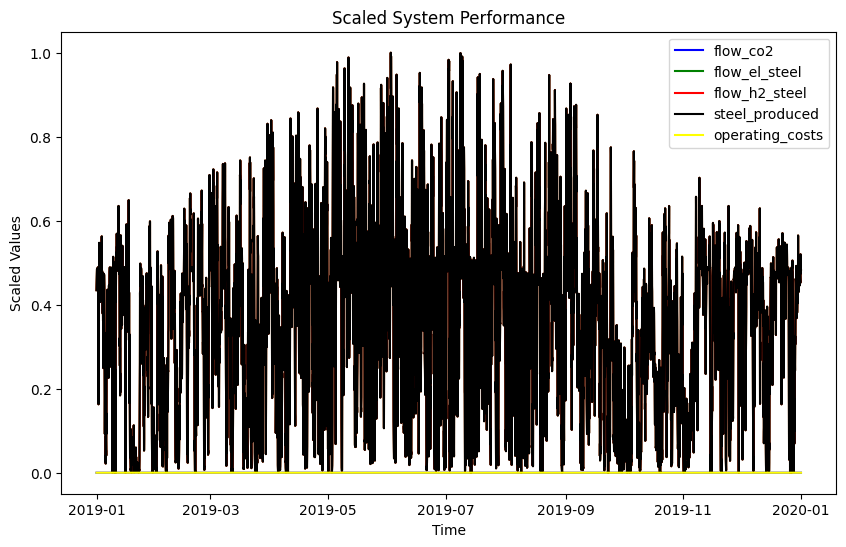

In [90]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# normalized values of system performance
system_performance_normed_values = scaler.fit_transform(system_performance)

# create new df with normalized values
system_performance_normed = pd.DataFrame(system_performance_normed_values, columns=system_performance.columns, index=system_performance.index)

# print(system_performance_normed.describe())
print(system_performance_normed.head())

# Plotten der normierten Werte
plt.figure(figsize=(10, 6))
plt.plot(system_performance_normed.index, system_performance_normed['flow_co2'], label='flow_co2', color='blue')
plt.plot(system_performance_normed.index, system_performance_normed['flow_el_steel'], label='flow_el_steel', color='green')
plt.plot(system_performance_normed.index, system_performance_normed['flow_h2_steel'], label='flow_h2_steel', color='red')
plt.plot(system_performance_normed.index, system_performance_normed['steel_produced'], label='steel_produced', color='black')
plt.plot(system_performance_normed.index, system_performance_normed['operating_costs'], label='operating_costs', color='yellow')

# Titel und Beschriftungen
plt.title('Scaled System Performance')
plt.xlabel('Time')
plt.ylabel('Scaled Values')
plt.legend()

plt.show()


### Combine System Performance into one Indicator

Sum weights: 5
                     flow_co2  flow_el_steel  flow_h2_steel  steel_produced  \
2019-01-01 00:00:00       0.0      43.465518      43.465519       43.465517   
2019-01-01 01:00:00       0.0      44.354387      44.354389       44.354386   
2019-01-01 02:00:00       0.0      44.758615      44.758616       44.758616   
2019-01-01 03:00:00       0.0      46.760318      46.760319       46.760318   
2019-01-01 04:00:00       0.0      47.962374      47.962376       47.962373   

                     operating_costs  weighted_sytem_performance_combined  
2019-01-01 00:00:00              0.0                            26.079311  
2019-01-01 01:00:00              0.0                            26.612633  
2019-01-01 02:00:00              0.0                            26.855169  
2019-01-01 03:00:00              0.0                            28.056191  
2019-01-01 04:00:00              0.0                            28.777425  


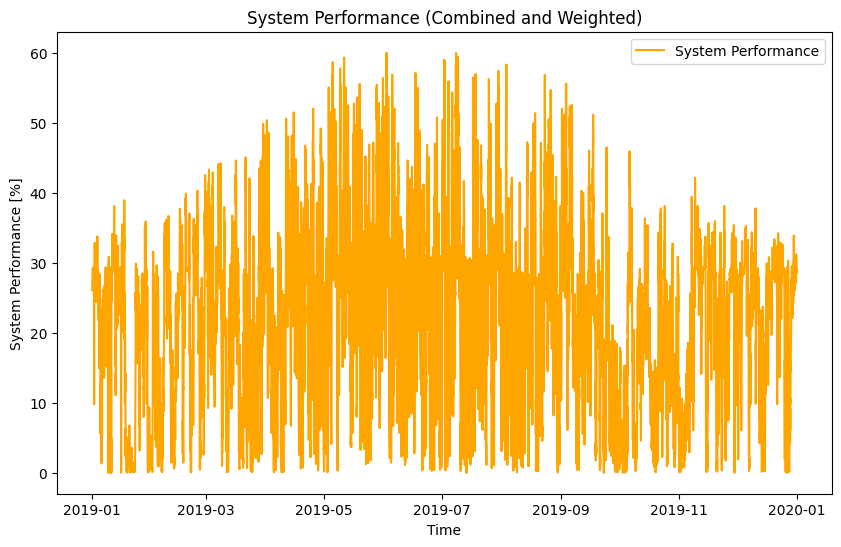

In [91]:
# define weights of each flow
weight_share_flow_co2 = 1
weight_share_flow_el_steel = 1
weight_share_flow_h2_steel = 1
weight_share_steel_produced = 1
weight_share_operating_costs = 1

sum_weights = weight_share_flow_co2 + weight_share_flow_el_steel + weight_share_flow_h2_steel + weight_share_steel_produced + weight_share_operating_costs
print(f"Sum weights: {sum_weights}")

#calculate weights
weight_flow_co2 = weight_share_flow_co2 / sum_weights
weight_flow_el_steel = weight_share_flow_el_steel / sum_weights
weight_flow_h2_steel = weight_share_flow_h2_steel / sum_weights
weight_steel_produced = weight_share_steel_produced / sum_weights
weight_operating_costs = weight_share_operating_costs / sum_weights

#weight dictionary
weights = {'flow_co2': weight_flow_co2, 'flow_el_steel': weight_flow_el_steel, 'flow_h2_steel': weight_flow_h2_steel, 'steel_produced': weight_steel_produced, 'operating_costs': weight_operating_costs}

# add weighted system performance to system performance df
system_performance_normed['weighted_sytem_performance_combined'] = (
    system_performance_normed['flow_co2'] * weights['flow_co2'] +
    system_performance_normed['flow_el_steel'] * weights['flow_el_steel'] +
    system_performance_normed['flow_h2_steel'] * weights['flow_h2_steel'] +
    system_performance_normed['steel_produced'] * weights['steel_produced'] +
    system_performance_normed['operating_costs'] * weights['operating_costs']
)
system_performance_normed = system_performance_normed * 100 #to display in percent

# print(system_performance['weighted_combined'].head())
print(system_performance_normed.head())

plt.figure(figsize=(10, 6))
plt.plot(system_performance_normed.index, system_performance_normed['weighted_sytem_performance_combined'], label='System Performance', color='orange', linestyle='-')

# Titel und Achsenbeschriftungen
plt.title('System Performance (Combined and Weighted)')
plt.xlabel('Time')
plt.ylabel('System Performance [%]')

# Zeige die Grafik an
plt.legend()
plt.show()


### Calculate one single, comparable Value for System Performance 

In [96]:
total_weighted_combined = system_performance_normed['weighted_sytem_performance_combined'].sum()

print(f"System Performance: {total_weighted_combined}")


System Performance: 187633.31611380103
